In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm

In [2]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [9]:
high = 1
low = -1
sample_size = 30000
sequence_size = 1000
degrees = 3
x = torch.linspace(high, low, sequence_size)
x = x.unsqueeze(1).expand(sequence_size, int(sample_size/degrees))
hold = []
for d in range(1, degrees+1):
    y = torch.zeros_like(x)
    for n in range(1, d+1):
        p = (high - low) * torch.rand(int(sample_size/degrees))
        y += p*(x**(n))
    hold.append(y)
y = torch.swapaxes(torch.hstack(hold), 0, 1)
x = torch.swapaxes(x, 0, 1)
print(f"x: {x.shape}")
print(f"y: {y.shape}")

x: torch.Size([10000, 1000])
y: torch.Size([30000, 1000])


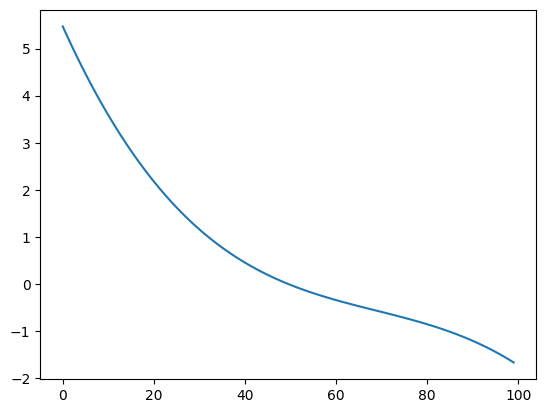

In [156]:
rand = np.random.randint(0, sample_size)
plt.plot(y[rand, :].detach().cpu().numpy());

In [150]:
torch.save(x, "x_data.pt")
torch.save(y, "y_targets.pt")

In [4]:
x_data = torch.load("x_data.pt")
print(f"x_data: {x_data.shape}")

y_val = torch.load("y_targets.pt")
print(f"y_val: {y_val.shape}")

x_data: torch.Size([10000, 100])
y_val: torch.Size([30000, 100])


/tmp/ipykernel_238242/1795573088.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_data = torch.load("x_data.pt")
/tmp/ipykernel_238242/1795573088.py:4: FutureWarning: Y

In [8]:
'''y_np = y.numpy()
y_np = y_np/np.max(np.abs(y_np))
sample_y = y_np[:, 0]
D = librosa.stft(sample_y, n_fft=2032, hop_length=8)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
spectrogram = np.expand_dims(S_db, axis=0)
spectrogram = torch.tensor(spectrogram).to(device)
print(spectrogram.shape)'''

'y_np = y.numpy()\ny_np = y_np/np.max(np.abs(y_np))\nsample_y = y_np[:, 0]\nD = librosa.stft(sample_y, n_fft=2032, hop_length=8)\nS_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)\nspectrogram = np.expand_dims(S_db, axis=0)\nspectrogram = torch.tensor(spectrogram).to(device)\nprint(spectrogram.shape)'

In [16]:
#y_np = y.numpy().swapaxes(0,1)
#y_np = y_np/np.max(np.abs(y_np))
y_np = y.numpy()/np.max(np.abs(y.numpy()))

def to_spectrogram(data, n_fft=2032, hop_length=4):
    D = librosa.stft(data, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    spectrogram = np.expand_dims(S_db, axis=0)
    return torch.tensor(spectrogram)

In [165]:
y_np.shape

(30000, 100)

In [17]:
to_spectrogram(y_np[0]).shape

torch.Size([1, 1017, 251])

In [5]:
'''all_spectrograms = []

for batch in tqdm(y_np):
    batch = batch.numpy()
    batch_spectrograms = [to_spectrogram(s) for s in batch]
    batch_tensor = torch.vstack(batch_spectrograms)
    all_spectrograms.append(batch_tensor)    '''

all_spectrograms = [to_spectrogram(s) for s in y_np]

/home/cymberly/miniconda3/envs/multifunc/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2032 is too large for input signal of length=100
  warnings.warn(


In [6]:
len(all_spectrograms)

30000

In [5]:
'''dataloader = DataLoader(y_np, batch_size=100)
all_spectrograms = []

for batch in tqdm(dataloader):
    batch = batch.numpy()
    batch_spectrograms = [to_spectrogram(s) for s in batch]
    batch_tensor = torch.vstack(batch_spectrograms)
    all_spectrograms.append(batch_tensor)    '''

  0%|          | 0/100 [00:00<?, ?it/s]/home/cymberly/miniconda3/envs/multifunc/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2032 is too large for input signal of length=1000
  warnings.warn(
100%|██████████| 100/100 [06:36<00:00,  3.96s/it]


In [7]:
all_spectrograms = torch.vstack(all_spectrograms).to(device)
all_spectrograms.shape

torch.Size([30000, 1017, 51])

In [9]:
all_spectrograms.shape

torch.Size([30000, 1017, 51])

In [10]:
import os

start = 0
end = int(all_spectrograms.size(0)/50)

for p in range(50):
    torch.save(all_spectrograms[start:end], os.path.join('spectrograms', f"spectrograms{p}.pt"))
    print(all_spectrograms[start:end].shape)
    start = end
    end += int(all_spectrograms.size(0)/50)

torch.Size([600, 1017, 51])
torch.Size([600, 1017, 51])
torch.Size([600, 1017, 51])


KeyboardInterrupt: 

In [32]:
y_arrays = []
for o in range(5):
    y_arrays.append(torch.load(f"spectrograms/spectrograms{o}.pt"))
y_data = torch.vstack(y_arrays)
y_data.shape

/tmp/ipykernel_3946026/2561874069.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  y_arrays.append(torch.load(f"spectrograms{o}.pt"))


torch.Size([5000, 1017, 126])

In [6]:
y_arrays[0].shape

torch.Size([10000, 1017, 126])

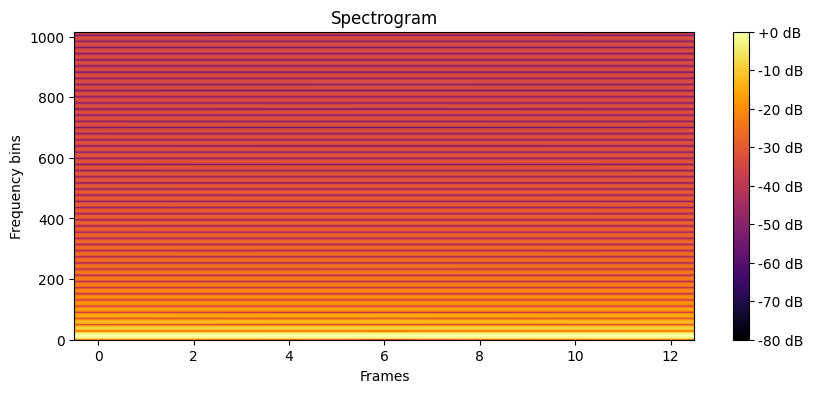

In [186]:
r = np.random.randint(1000)
spectrogram_np = all_spectrograms[r].cpu().numpy().squeeze()

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram_np, aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Frames')
plt.ylabel('Frequency bins')
plt.show()